In [3]:
import pandas as pd 
import numpy as np 
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import resample
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [4]:
# import validation data
df = pd.read_csv('validation_set.csv')
train = pd.read_csv('train_set.csv')
df.shape,train.shape

((421113, 6), (3790012, 6))

In [3]:
x_train,x_test,y_train,y_test = train_test_split(train.drop(columns=['isFraud']),train['isFraud'],random_state=42,test_size=0.2)

In [4]:
# reset index
x_train = x_train.reset_index().drop(columns=['index'])
x_test = x_test.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
y_test = y_test.reset_index().drop(columns=['index'])

In [5]:
x_train.shape,x_test.shape

((3032009, 5), (758003, 5))

In [6]:
x_val,y_val = df.drop(columns=['isFraud']),df['isFraud']

In [7]:
x_val.shape,y_val.shape

((421113, 5), (421113,))

In [8]:
pipeline = joblib.load('fraud_pipeline.joblib')

In [9]:
x_test_transformed = pipeline.named_steps['preprocessing'].transform(x_test)

In [10]:
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

In [11]:
x_test_transformed_df = pd.DataFrame(x_test_transformed,columns=feature_names)

In [12]:
model = pipeline.named_steps['model']

In [32]:
# Apply SHAP 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_transformed_df)

C:\Users\Yogesh\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


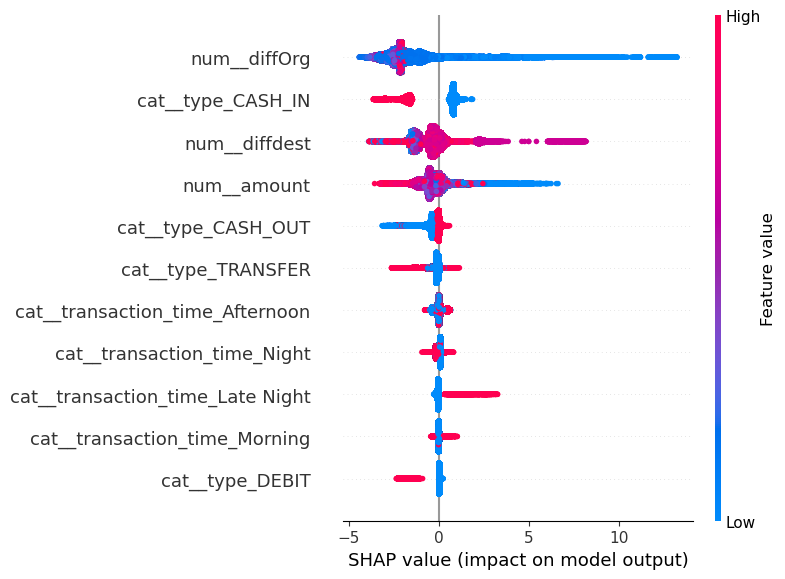

In [33]:
shap.summary_plot(shap_values,x_test_transformed_df)

### Feature-by-feature behavior


1. num__diffOrg (Sender account balance change)

    Strongest feature in the model
    
    Large negative values (big reduction) → very strong push toward FRAUD
    
    Small reduction or increase → close to zero or slight fraud push
    
    Very asymmetric spread → model is highly sensitive to this feature
    
    Model logic:
    
    Heavy money outflow from sender = strong fraud signal



2. cat__type_CASH_IN

    CASH_IN = 1 (red) → strong push toward NON-FRAUD
    
    CASH_IN = 0 (blue) → small push toward FRAUD

    Model logic:
    
    Cash-in transactions are considered safe


3. num__diffdest (Receiver balance change)

Large positive increase (red) → strong push toward FRAUD

    High Moderate positive increament -> toward fraud
    
    Moderate positive change → SHAP values clustered near zero (model silent)

    Negative values (receiver reduction) → toward non fraud

    High positive increment -> model toward slightly non fraud
    
    Model logic:
    
    Abnormal receiver balance movement (up or down) = fraud
    Normal increase = ignored



4. num__amount

    Low amounts (blue) → push toward FRAUD
    
    Medium amounts → mixed behavior, overlapping SHAP values
    
    High amounts (red) → push toward NON-FRAUD
    
    Model logic:
    
    Fraud tends to happen in smaller transactions
    Large transactions are usually legitimate


5. cat__type_CASH_OUT

    Most points tightly around zero
    
    When effect exists → slight push toward NON-FRAUD
    
    Model logic:
    
    CASH_OUT alone doesn’t indicate fraud
    


6. cat__type_TRANSFER

    Points heavily overlapped around zero
    
    No clean separation between fraud/non-fraud
    
    Model logic:
    
    TRANSFER type provides no reliable boundary


7. Transaction Time Features
   
    Late Night
    
    Late Night = 1 (red) → clear push toward FRAUD
    
    Otherwise → near zero
    
    Model logic:
    
    Late-night transactions are suspicious



8. Morning / Afternoon / Night
    
    Almost entirely silent
    
    Very weak or no influence
    
    Model logic:
    
    Time matters only at late night
    


8. cat__type_DEBIT

    Weak influence
    
    Mostly pushes toward NON-FRAUD
    
    Model logic:
    
    Debit transactions are generally safe
    


## this tells us about out model 

1. Strong fraud signals

    Big sender balance drop
    
    high Moderate receiver balance jump
    
    Low transaction amount
    
    Late-night timing

2.  Strong non-fraud signals

    CASH_IN
    
    High amount
    
    DEBIT

4. Weak / unreliable signals

    TRANSFER type
    
    Most time slots

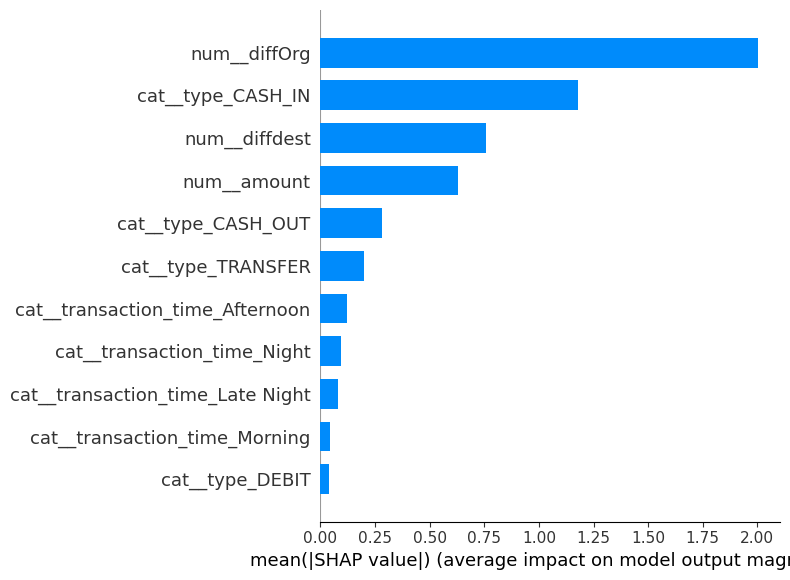

In [35]:
shap.summary_plot(shap_values, x_test_transformed_df, plot_type="bar")


# This Shows :

1. num__diffOrg is the most important feature by far → model relies mainly on sender balance change.

2. cat__type_CASH_IN is the second most important → transaction type matters, especially cash-in.

3. num__diffdest and num__amount have moderate importance.

4. All other features (CASH_OUT, TRANSFER, time features, DEBIT) have very little impact.

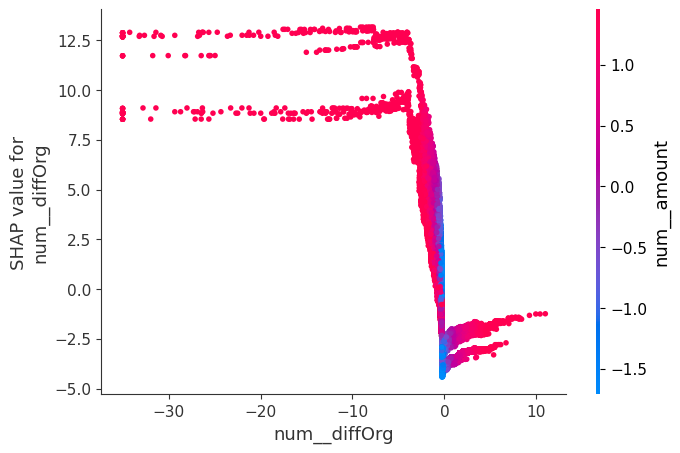

In [36]:
shap.dependence_plot("num__diffOrg",shap_values, x_test_transformed_df,interaction_index="num__amount")

# This Graph Shows : 

1. Sender account reduction is the main decision switch

    When num__diffOrg is highly negative (large sender balance drop):
    
    SHAP values are very high (+10 to +13)
    
    Model strongly predicts FRAUD
    
    This happens regardless of color
    
    Red (high amount) and Blue (low amount)

    Means : Amount does NOT control the fraud decision here.

2. Sharp transition around sender change ≈ 0

    As sender reduction approaches 0:
    
    SHAP values collapse from strong fraud → near zero
    
    Right after crossing 0 (small increase / no reduction):
    
    SHAP becomes negative
    
    Model shifts to NON-FRAUD

    Means : Sender balance change is acting like a decision boundary

3. Transaction amount has weak interaction

    At high fraud SHAP values, you see:
    
    Both high amount (red) and low amount (blue)
    
    At low / negative SHAP values, again:
    
    Both red and blue points exist

    There is no clear vertical color separation

    Means: Amount does not amplify or suppress fraud once sender reduction is known.

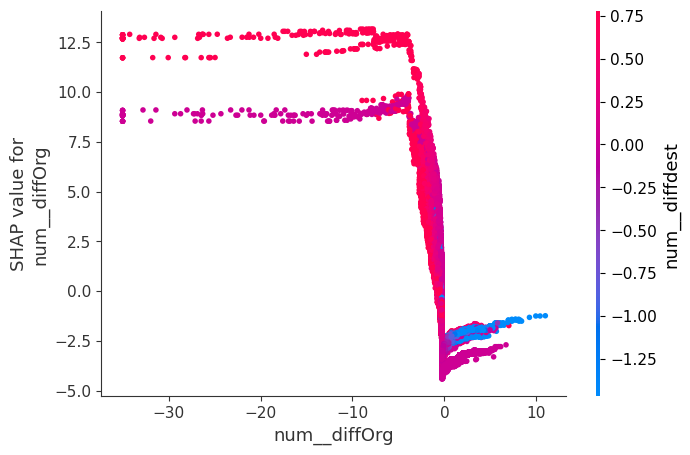

In [37]:
shap.dependence_plot("num__diffOrg",shap_values, x_test_transformed_df,interaction_index="num__diffdest")

# This Shows 

1. Sender reduction is still the primary driver

    When sender reduction is very high (large negative diffOrg):
    
    SHAP values are extremely high (~12–13)
    
    Model strongly predicts FRAUD
    
    This happens for all colors, but…

    Means : Sender balance drop remains the main fraud trigger.

2. Receiver increment modulates fraud strength

    This is the new insight.
    
    At the same sender reduction level:
    
    High receiver increase (red) → higher SHAP
    
    Moderate receiver increase (pink) → slightly lower SHAP
    
    Receiver decrease (blue) → much lower SHAP
    
    Means : Receiver balance change amplifies or dampens the fraud signal created by sender reduction.

3. Fraud signal appears even with moderate sender reduction

    When sender reduction is not extreme, but:
    
    Receiver increase is high
    
    SHAP values are still positive
    
    Means : A strong receiver increment can partially compensate for smaller sender reductions and still push toward fraud.

4. Non-fraud region is very consistent

    When:
    
    Sender balance increases (diffOrg > 0) and
    
    Receiver balance decreases (blue points)
    
    SHAP values are clearly negative
    
    Means : Legitimate money flow (sender gains, receiver loses) is strongly classified as non-fraud.



### Overall : The model primarily detects fraud through sender balance reduction, but receiver balance change meaningfully interacts with this signal. Large receiver increments amplify fraud risk, while moderate increments weaken it. Even when sender reduction is not extreme, a strong receiver increment can still push the model toward fraud. Conversely, sender balance increases combined with receiver decreases consistently lead to non-fraud predictions.

### in one-line , Sender balance change is the main switch, and receiver balance change is the volume knob.

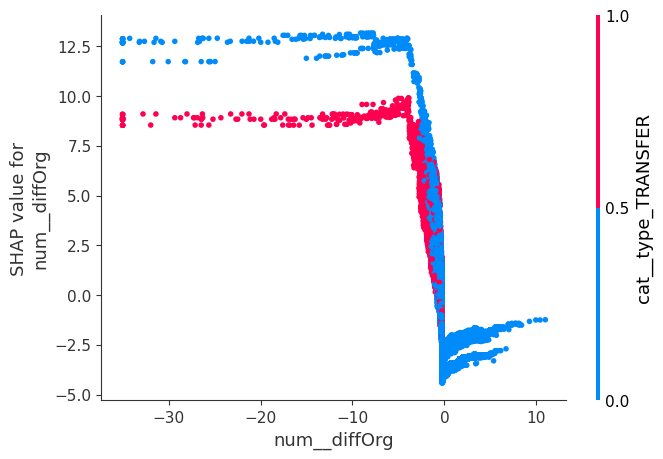

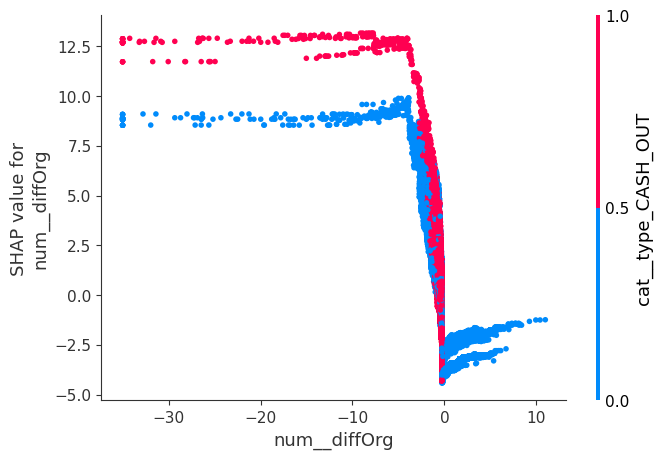

In [38]:
for i in ['cat__type_TRANSFER','cat__type_CASH_OUT']:
    shap.dependence_plot(
        "num__diffOrg",
        shap_values,
        x_test_transformed_df,
        interaction_index=i
    )

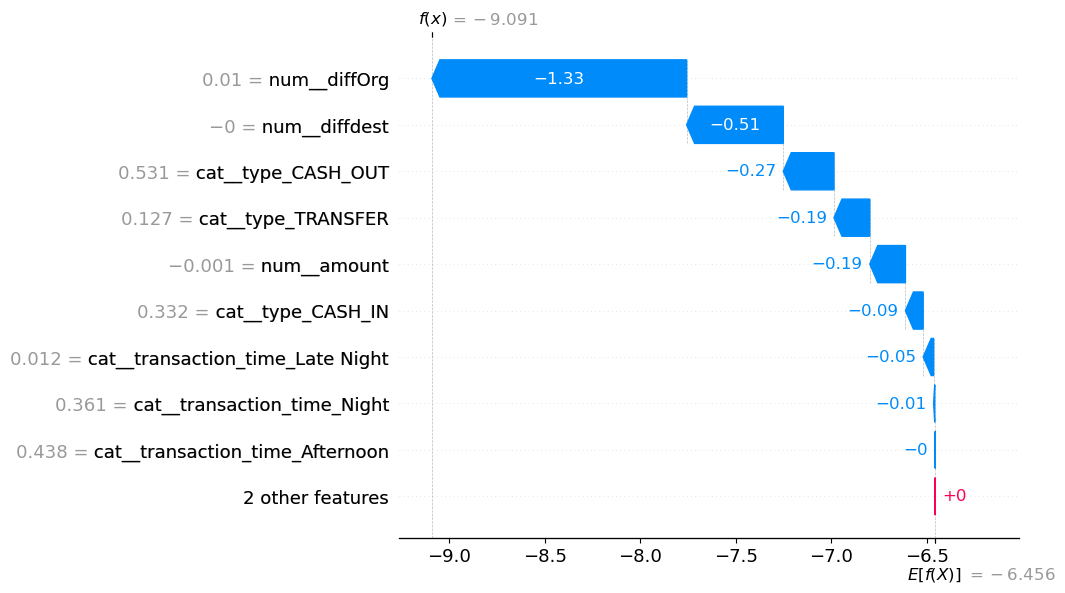

In [39]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values.mean(axis=0),
        base_values=explainer.expected_value,
        data=x_test_transformed_df.mean()
    )
)

Since the dataset is highly imbalanced and non-fraud patterns dominate, the model’s expected value is strongly biased toward non-fraud.


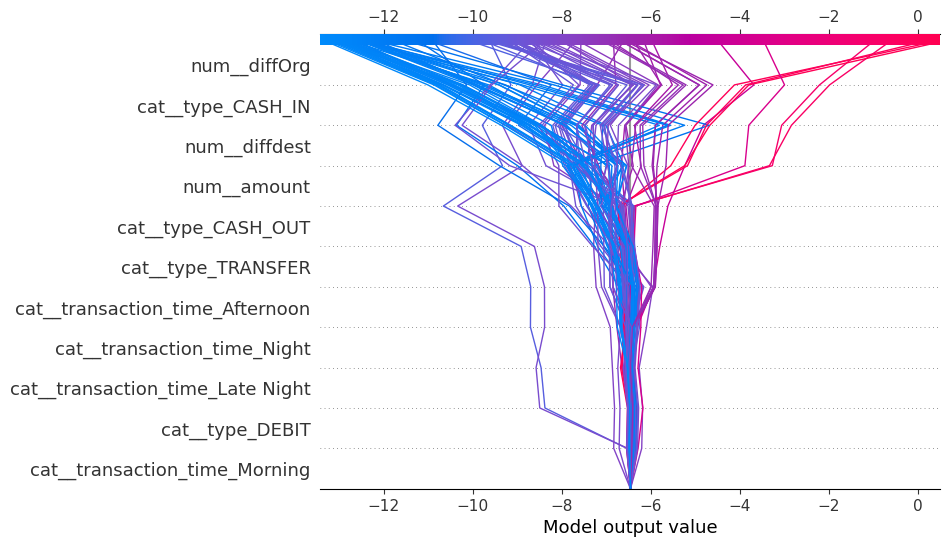

In [40]:
shap.decision_plot(
    explainer.expected_value,
    shap_values[:100],
    x_test_transformed_df.iloc[:100]
)

### This Shows models prediction flow 

1. num__diffOrg (sender balance change) – first and biggest move

    This feature creates the largest shift for almost every transaction.
    
    Large sender balance reduction pushes predictions strongly toward FRAUD
    
    Sender balance increase / small reduction pushes toward NON-FRAUD

    Means : The model’s decision starts with sender balance change.

2. cat__type_CASH_IN – strong corrective signal

    When the transaction is CASH_IN, the line moves back toward NON-FRAUD
    
    This can partially cancel a fraud push created by sender reduction
    
    Means : CASH_IN transactions are treated as safe even if money movement looks suspicious.

3. num__diffdest (receiver balance change) – amplifies or weakens

    Large receiver increase pushes predictions further toward FRAUD
    
    Receiver decrease pulls predictions back toward NON-FRAUD
    
    Means : The model checks whether money actually accumulates at the receiver.

4. num__amount – small adjustment, not a decision maker

    Amount causes small left/right shifts
    
    It never flips the decision by itself
        
    Means : Amount fine-tunes the score but does not decide fraud.

5. Remaining features – minimal influence

    CASH_OUT, TRANSFER, time of day, DEBIT:
    
    Small, narrow movements
    
    Rarely change the final decision
    
    Means : These features provide context, not decisions.

### Overall , The model first looks at how much money leaves the sender. If the drop is large, it suspects fraud. Then it checks where the money went (receiver balance change).Finally, it uses transaction type and amount to slightly adjust the confidence.

### insort , Fraud decisions are driven by abnormal money flow from sender to receiver; all other features only adjust confidence.

# Model Weakness Analysis

## For all fraud cases model behaviour

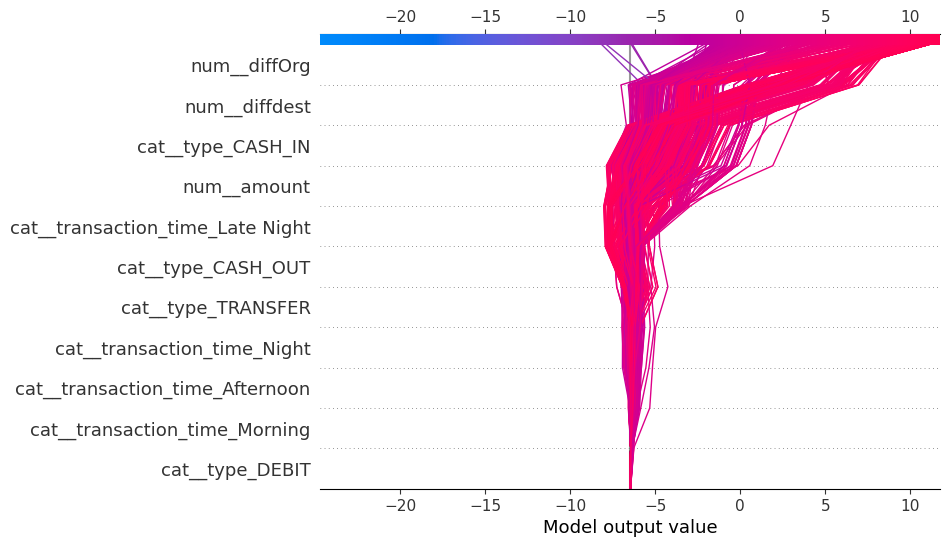

In [41]:
fraud_idx = y_test[y_test['isFraud'] == 1].index[:1000]
shap.decision_plot(
    explainer.expected_value,
    shap_values[fraud_idx],
    x_test_transformed_df.loc[fraud_idx]
)

# When Fraud cases detected

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


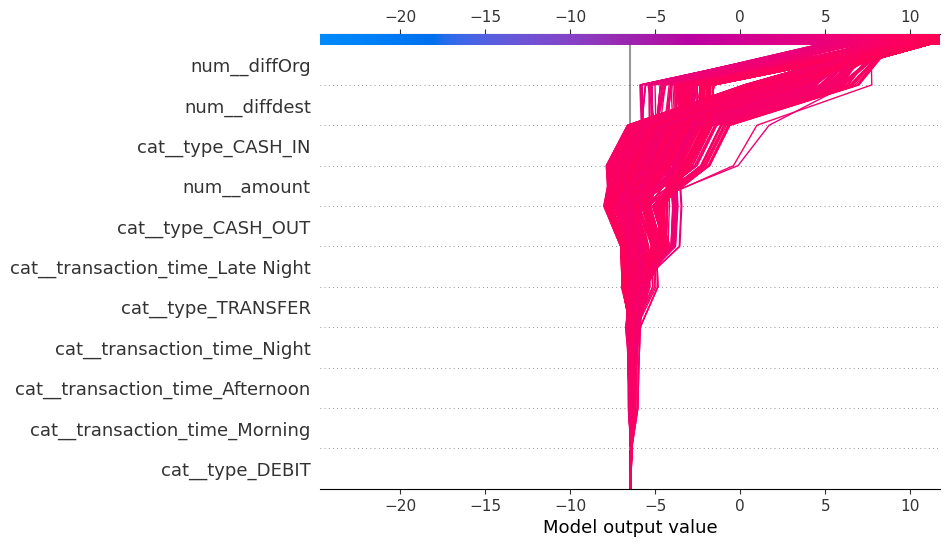

In [42]:
y_prob = pipeline.predict_proba(x_test)[:,1]
y_test_pred = (y_prob>0.99).astype('int')

missed_idx = y_test[(y_test['isFraud'] == 1) & (y_test_pred == 1)].index
shap.decision_plot(
    explainer.expected_value,
    shap_values[missed_idx],
    x_test_transformed_df.loc[missed_idx]
)

In [46]:
# when model detected the fraud
x_test_transformed_df.loc[missed_idx][['num__amount','num__diffOrg','num__diffdest']].describe()

,num__amount,num__diffOrg,num__diffdest
count,1102.000000,1102.000000,1102.000000
mean,1.584959,-6.773110,0.797052
std,1.751694,8.887781,1.684076
min,-4.794040,-35.010499,0.033564
25%,0.295141,-7.927703,0.033564
50%,1.626355,-3.252873,0.033564
75%,2.757432,-1.079614,0.813935
max,4.935799,-0.284643,7.871867


# When Model Not Able to Detect Fruad Cases

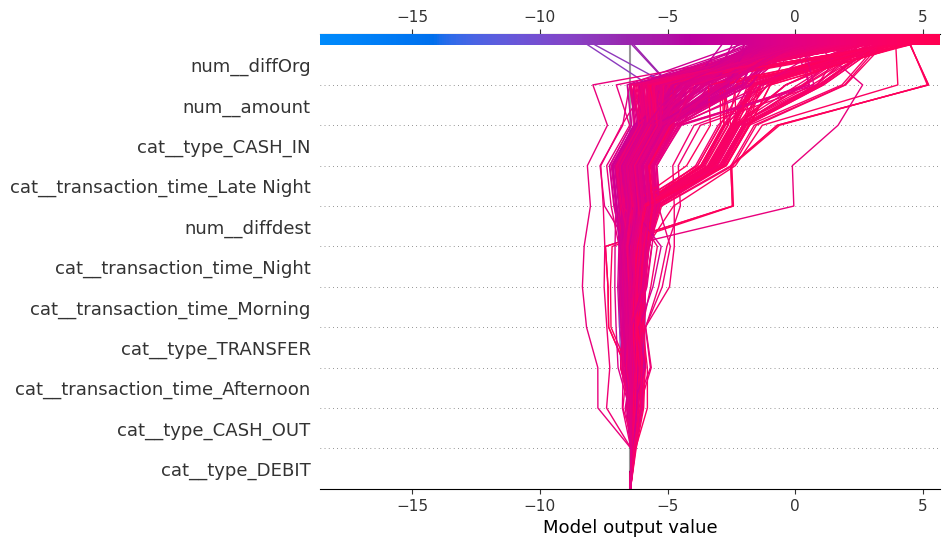

In [47]:
missed_idx = y_test[(y_test['isFraud'] == 1) & (y_test_pred == 0)].index

shap.decision_plot(
    explainer.expected_value,
    shap_values[missed_idx],
    x_test_transformed_df.loc[missed_idx]
)

In [48]:
# when model not able to detect fruad
x_test_transformed_df.loc[missed_idx][['num__amount','num__diffOrg','num__diffdest']].describe()

,num__amount,num__diffOrg,num__diffdest
count,401.000000,401.000000,401.000000
mean,-0.258818,-0.958324,0.212419
std,1.077897,0.603225,0.205013
min,-4.794040,-2.816288,-1.729751
25%,-0.873193,-1.303077,0.089712
50%,-0.120000,-0.777510,0.171056
75%,0.530991,-0.476244,0.315356
max,1.451339,-0.284643,1.516992


## This Shows : 

### 1. When fraud WAS detected 

Amount : Mean ≈ 1.58 , Mostly medium to high amounts. 

Sender balance (num_diffOrg) : Mean ≈ -6.77 , Strongly negative. Means big money going out from sender.

Receiver balance (num_diffdest) : Mean ≈ 0.79 , Often positive , Receiver balance clearly increases.

Means : 

    Model catches fraud when: Sender loses a lot of money ,Receiver gains money.

### 3. When fraud was NOT detected

Amount : Mean ≈ -0.26 , Mostly small or moderate amounts

Sender balance : Mean ≈ -0.96 , Only small reduction , No sharp drop

Receiver balance : Mean ≈ 0.21 , Small increase , Weak signal

Means : Model misses fraud when , Amount is small , Sender balance does not drop much , Receiver balance increases only slightly. These cases look normal, so model gets confused.

# Models exact weaknesss

In [50]:
# Combine everything into one df
fraud_df = x_test_transformed_df.copy()
fraud_df['isFraud'] = y_test['isFraud'].values
fraud_df['pred'] = y_test_pred

# Keep only actual frauds
fraud_df = fraud_df[fraud_df['isFraud'] == 1]

# Split detected vs missed
detected = fraud_df[fraud_df['pred'] == 1]
missed   = fraud_df[fraud_df['pred'] == 0]


In [51]:
def stacked_fraud_hist(feature, bins=20):
    plt.figure(figsize=(8, 5))

    plt.hist(
        [missed[feature], detected[feature]],
        bins=bins,
        stacked=True,
        label=['Missed Fraud', 'Detected Fraud'],
        color=['#d62728', '#2ca02c'],
        alpha=0.85
    )

    plt.xlabel(feature)
    plt.ylabel('Number of Fraud Transactions')
    plt.title(f'Fraud Detection by {feature}')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

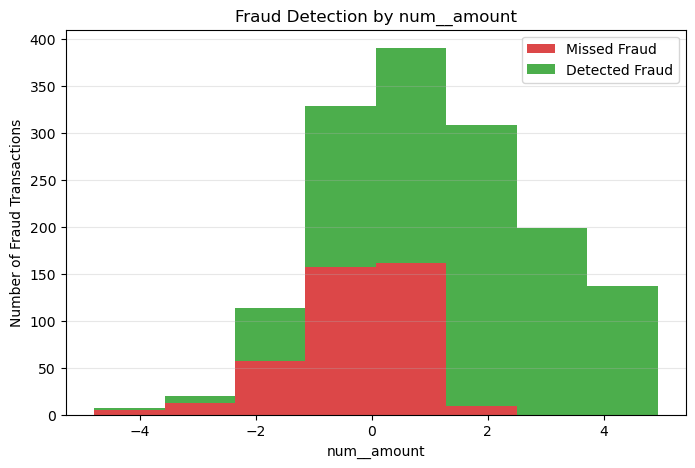

In [52]:
stacked_fraud_hist('num__amount', bins=8)

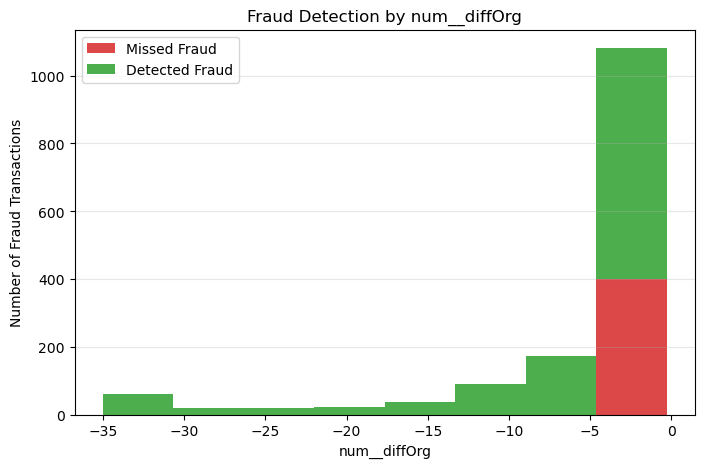

In [53]:
stacked_fraud_hist('num__diffOrg', bins=8)

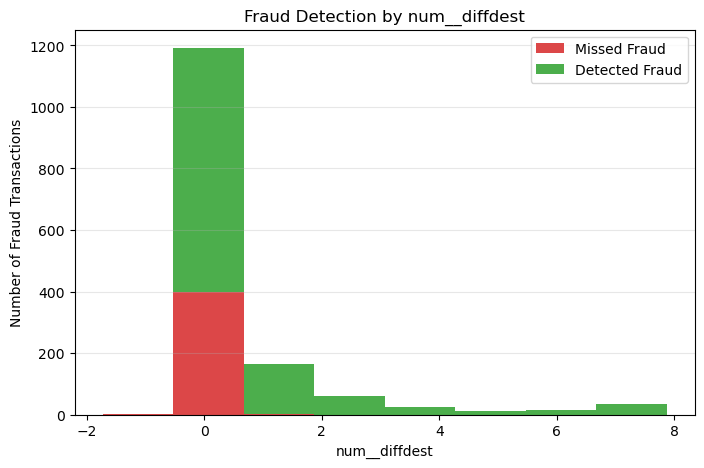

In [54]:
stacked_fraud_hist('num__diffdest', bins=8)

### 1.Fraud by transaction amount (num_amount)

What the graph shows : 

    Green (detected fraud) dominates at higher amounts
    
    Red (missed fraud) appears mostly at low to moderate amounts
    
    Very few misses at very high amounts

Means : 
    Model is good at catching big transactions
    Model misses small or medium amount fraud

### 2. Fraud by sender balance reduction (num_diffOrg)

What the graph shows : 

    When sender balance drop is very large (strongly negative) → mostly detected
    
    When balance drop is small or moderate → many missed frauds

Means : 
    Model heavily depends on how much money leaves the sender
    If sender loss is not big, model often thinks it is normal

### 3. Fraud by receiver balance increase (num_diffdest)

What the graph shows : 

    High receiver balance increase → mostly detected
    
    Low or moderate increase → many missed frauds

Means : 
    Model expects clear receiver gain
    If receiver gain is small, fraud looks harmless → missed

### 4. Putting all three together 

    Model misses fraud when
    
    Transaction amount is moderate
    
    Sender balance reduction is not very high
    
    Receiver balance increase is not very high


# Model Improvement

# 1. Rule Based + Model 

In [35]:
#define rule 
def rule_based_flag(df):
    rule_flag = (((df['num__diffOrg'] >= -5) & (df['num__diffOrg'] <= 0)) & ((df['cat__type_TRANSFER']==1) | (df['cat__type_CASH_OUT']==1))
                & (df['cat__transaction_time_Late Night'] == 1) & ((df['num__diffdest'] >= -2 ) & (df['num__diffdest'] >= 2)))    
    return rule_flag.astype(int)

In [26]:
x_test_transformed_df.head()

,num__amount,num__diffOrg,num__diffdest,cat__type_CASH_IN,cat__type_CASH_OUT,cat__type_DEBIT,cat__type_TRANSFER,cat__transaction_time_Afternoon,cat__transaction_time_Late Night,cat__transaction_time_Morning,cat__transaction_time_Night
0,-2.286178,-0.304926,0.040204,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.022614,-0.284701,0.195759,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.133208,0.862021,-0.892988,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.736226,0.093452,-0.042091,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.604929,-0.489216,0.330215,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
def dynamic_threshold(row):
    
    if rule_based_flag(row) == 1:
        return 0.10   # easier to flag
    else:
        return 0.99   # strict


In [38]:
x_test_transformed_df.apply(dynamic_threshold,axis=1)

0         0.99
1         0.99
2         0.99
3         0.99
4         0.99
          ... 
757998    0.99
757999    0.99
758000    0.99
758001    0.99
758002    0.99
Length: 758003, dtype: float64

In [39]:
y_prob = pipeline.predict_proba(x_test)[:,1]

model_pred = (y_prob>x_test_transformed_df.apply(dynamic_threshold,axis=1)).astype('int')
model_pred

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


0         0
1         0
2         0
3         0
4         0
         ..
757998    0
757999    0
758000    0
758001    0
758002    0
Length: 758003, dtype: int32

In [40]:
print(classification_report(y_test['isFraud'],model_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    756500
           1       0.97      0.73      0.84      1503

    accuracy                           1.00    758003
   macro avg       0.99      0.87      0.92    758003
weighted avg       1.00      1.00      1.00    758003



In [41]:
print(confusion_matrix(y_test['isFraud'],model_pred))

[[756470     30]
 [   401   1102]]


In [61]:
# normal 
y_prob = pipeline.predict_proba(x_test)[:,1]
y_pred = (y_prob>0.99).astype('int')
print(classification_report(y_test['isFraud'],y_pred))

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    756500
           1       0.97      0.73      0.84      1503

    accuracy                           1.00    758003
   macro avg       0.99      0.87      0.92    758003
weighted avg       1.00      1.00      1.00    758003



# No Benefit of Apply Rule Based Strategy

# 2. Recall boster Model

In [39]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3032009, 5), (758003, 5), (3032009, 1), (758003, 1))

In [40]:
y_train = pd.Series(y_train['isFraud'])

In [41]:
y_test = pd.Series(y_test['isFraud'])

In [42]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3032009, 5), (758003, 5), (3032009,), (758003,))

In [43]:
# base model 
y_train_prob = pipeline.predict_proba(x_train)[:,1]
threshold = 0.9

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [44]:
# detected fraud & missed fraud
train_pred = (y_train_prob >= threshold).astype('int')

# fraud that main model Failed to catch
missed_fraud_idx = (y_train == 1) & (train_pred ==0)

# non-fraud that main model correctly passed
normal_idx = (y_train ==0) & (train_pred ==0)


# preparing data for recall booster model
x_missed_fraud = x_train[missed_fraud_idx]
x_normal = x_train[normal_idx]

y_missed_fraud = y_train[missed_fraud_idx]
y_normal = y_train[normal_idx]

x_normal_down = resample(x_normal, n_samples=len(x_missed_fraud)*10,random_state=42)

y_normal_down = y_normal.loc[x_normal_down.index]


x_booster = pd.concat([x_missed_fraud,x_normal_down])
y_booster = pd.concat([y_missed_fraud,y_normal_down])

In [45]:
x_booster.shape

(12958, 5)

In [46]:
# preprocessing
preprocessing  = pipeline.named_steps['preprocessing']
# training a simple recall booster model
booster_model = LGBMClassifier(n_estimators=200,num_leaves=16,max_depth=8,learning_rate=0.05,class_weight={0:1, 1:3},random_state=42)

In [47]:
booster_pipeline = Pipeline([
        ('preprocessing',preprocessing),
        ('booster_model',booster_model)
])

In [48]:
booster_pipeline.fit(x_booster,y_booster)

[LightGBM] [Info] Number of positive: 1178, number of negative: 11780
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 12958, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230769 -> initscore=-1.203973
[LightGBM] [Info] Start training from score -1.203973


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', PowerTransformer(),
                                                  ['amount', 'diffOrg',
                                                   'diffdest']),
                                                 ('cat', OneHotEncoder(),
                                                  ['type',
                                                   'transaction_time'])])),
                ('booster_model',
                 LGBMClassifier(class_weight={0: 1, 1: 3}, learning_rate=0.05,
                                max_depth=8, n_estimators=200, num_leaves=16,
                                random_state=42))])

# Evaluation of Main Model + Booster Model

In [49]:
p_main = pipeline.predict_proba(x_test)[:,1]
p_booster = booster_pipeline.predict_proba(x_test)[:,1]

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [50]:
y_final_pred = np.where((p_main >= 0.99)|(p_booster>=0.75),1,0)

In [51]:
print(classification_report(y_test, y_final_pred))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99    756500
           1       0.05      0.76      0.10      1503

    accuracy                           0.97    758003
   macro avg       0.53      0.86      0.54    758003
weighted avg       1.00      0.97      0.98    758003



In [55]:
final_decision = []

for i in range(len(x_test)):
    if p_main[i] >= 0.99:
        final_decision.append("BLOCK")     # High confidence fraud
    elif p_booster[i] >= 0.75:
        final_decision.append("REVIEW")    # Suspicious, manual review
    else:
        final_decision.append("ALLOW")


In [56]:
x_test_com_df = x_test.copy()
x_test_com_df['isfraud'] = y_test
x_test_com_df['decision'] = final_decision


<Axes: xlabel='decision', ylabel='isfraud'>

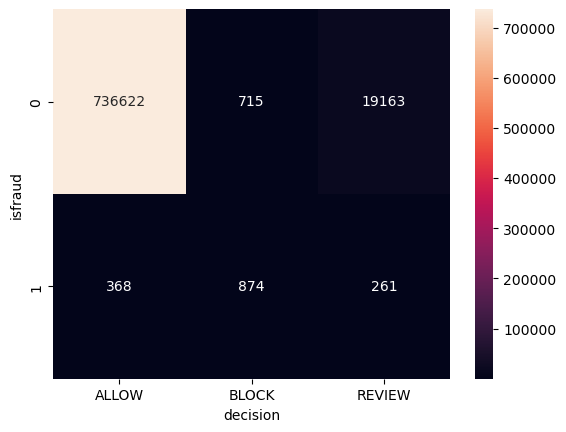

In [57]:
sns.heatmap(pd.crosstab(index=x_test_com_df['isfraud'],columns=x_test_com_df['decision']),annot=True,fmt="d")
# result of Lightgbm + recall boster Model

# Not Good

# Single LightGBM Model Evaluation

### Threshold selection On Training Data

In [28]:
p_main = pipeline.predict_proba(x_train)[:,1]

final_decision = []

for i in range(len(x_train)):
    if p_main[i] >= 0.99:
        final_decision.append("BLOCK")     # High confidence fraud
    elif (p_main[i] <= 0.99) & (p_main[i] >= 0.30):
        final_decision.append("REVIEW")    # High Risk Fraud
    else:
        final_decision.append("ALLOW")

C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [29]:
temp = pd.DataFrame()
temp['y_pred'] = final_decision
temp['org'] = y_train

<Axes: xlabel='y_pred', ylabel='org'>

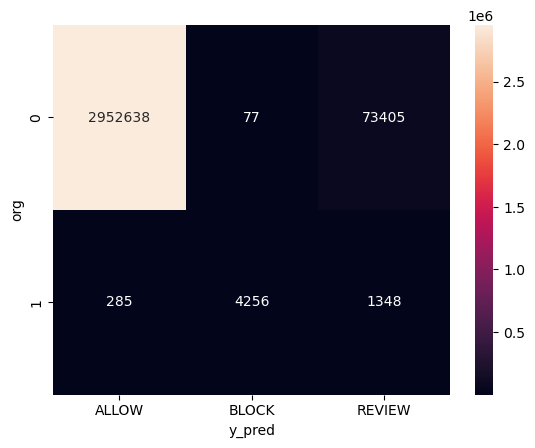

In [30]:
sns.heatmap(pd.crosstab(columns=temp['y_pred'],index=temp['org']),annot=True,fmt="d")

In [ ]:
# Recall = 93%
# Precision = 98%
# review rate = 2%

# On Testing Data

In [35]:
p_main = pipeline.predict_proba(x_test)[:,1]

final_decision = []

for i in range(len(x_test)):
    if p_main[i] >= 0.99:
        final_decision.append("BLOCK")     # High confidence fraud
    elif (p_main[i] <= 0.99) & (p_main[i] >= 0.30):
        final_decision.append("REVIEW")    # High Risk Fraud
    else:
        final_decision.append("ALLOW")


C:\Users\Yogesh\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
x_test_com_df = x_test.copy()
x_test_com_df['isfraud'] = y_test
x_test_com_df['decision'] = final_decision


In [38]:
x_test.shape

(758003, 5)

<Axes: xlabel='decision', ylabel='isfraud'>

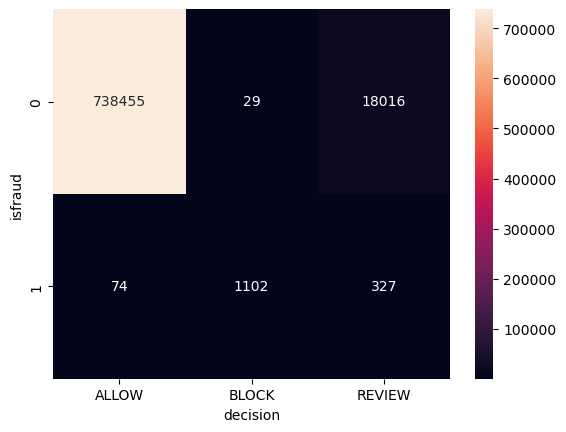

In [37]:
sns.heatmap(pd.crosstab(index=x_test_com_df['isfraud'],columns=x_test_com_df['decision']),annot=True,fmt="d")
# result of Single Lightgbm model

In [ ]:
# Recall = 93%
# Precision = 97%
# Review Rate = 2%

# Model Comparison: LightGBM vs LightGBM + Recall Booster

This section compares the performance of:
- **Model-1:** Combined Model (Main LightGBM + Recall Booster)
- **Model-2:** Single Main LightGBM Model

The comparison is based on confusion matrices, derived metrics, and business interpretation.
 -

## ✅ Model-1: Combined Model (Main LightGBM + Recall Booster)

### Confusion Matrix

| isfraud | ALLOW | BLOCK | REVIEW |
|--------|-------:|------:|-------:|
| **0 (Non-Fraud)** | 736,622 | 715 | 19,163 |
| **1 (Fraud)** | 368 | 874 | 261 |

---

### Numbers Used

- **True Fraud Blocked (TP)** = 874  
- **False Block (FP)** = 715  
- **Missed Fraud (FN)** = 368  
- **Fraud Sent to Review** = 261  
- **Non-fraud Sent to Review** = 19,163  
- **Total Transactions** = **756,500**

-
-

### Metrics

**Precision**


874 / (874 + 715) = 0.55 (~55.0%)


**Recall**


874 / (874 + 368) = 0.7037 (~70.4%)

**Review Rate**

(261 + 19,163) / 756,500 = 0.0257 (~2.57%)


## ✅ Model-2: Single Main LightGBM Model

### Confusion Matrix

| isfraud | ALLOW | BLOCK | REVIEW |
|--------|-------:|------:|-------:|
| **0 (Non-Fraud)** | 738,455 | 29 | 18,016 |
| **1 (Fraud)** | 74 | 1,102 | 327 |

---

### Numbers Used

- **True Fraud Blocked (TP)** = 1,102  
- **False Block (FP)** = 29  
- **Missed Fraud (FN)** = 74  
- **Fraud Sent to Review** = 327  
- **Non-fraud Sent to Review** = 18,016  
- **Total Transactions** = **756,500**

---

### Metrics

**Precision**


1102 / (1102 + 29) = 0.9743 (~97.4%)

**Recall**


1102 / (1102 + 74) = 0.9371 (~93.7%)

**Review Rate**


(327 + 18,016) / 756,500 = 0.0242 (~2.42%)


##  Final Comparison Summary

| Metric | Combined Model | Single Model |
|------|----------------|--------------|
| Precision | ~55% | ~97% |
| Recall | ~70% | ~94% |
| Review Rate | ~2.6% | ~2.4% |
| Fraud Safety | low | High |
| Customer Safety | low | High |

---

**Overall, the single LightGBM model performs better.
Its decisions are more reliable, it misses fewer fraud cases, and its review rate is almost the same as the combined model.
This makes the single model a better balance between fraud detection and customer experience.** 


## Final Decision: Loss–Cost Optimized Strategy

From the comparison of both approaches, it is clear that there is a **direct trade-off between fraud detection (recall) and review volume**:

- Increasing recall reduces missed fraud but significantly **increases manual reviews**.
- Reducing review volume leads to **more missed fraud cases**.



---

## Why Loss–Cost Optimization?

Each action has a cost:

- **Missed Fraud** → Direct financial loss  
- **Manual Review** → Operational cost  
- **False Block** → Customer dissatisfaction  

The objective is to **minimize total business cost**.

---

## Model Choice

Based on this perspective:

- The **single LightGBM model** provides a **better balance** between:
  - Fraud detection capability
  - Operational review workload
- It achieves **strong precision** while keeping the **review rate low**
- The combined model improves recall, but at the cost of **excessive reviews**, which is not optimal under cost constraints

Therefore, the **single LightGBM model is the most suitable choice** for a loss–cost optimized system.

---


